In [1]:
import torch
from sentence_transformers import SentenceTransformer

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

model = SentenceTransformer("clip-ViT-B-16", device="cpu")
print(" Model loaded successfully!")


PyTorch version: 2.8.0+cpu
CUDA available: False


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


 Model loaded successfully!


In [2]:
import pandas as pd
import os

shard_path = r"D:\BookInsight\data\processed\shards\amazon_books_shard_0.parquet"
df = pd.read_parquet(shard_path)

print(" Loaded:", shard_path)
print(" T·ªïng s·ªë d√≤ng:", len(df))
print(df.columns.tolist())


 Loaded: D:\BookInsight\data\processed\shards\amazon_books_shard_0.parquet
 T·ªïng s·ªë d√≤ng: 88964
['main_category', 'rating_number', 'unique_id', 'title', 'subtitle', 'cleaned_description', 'cleaned_features', 'is_free', 'is_missing', 'is_outlier', 'details_text', 'author_name', 'author_about', 'author_avatar', 'categories', 'publisher', 'language', 'average_rating', 'isbn_10', 'price_temp_clean', 'page_count', 'isbn_13', 'main_images', 'document_text']


In [3]:
IMG_COL = "main_images"
df_img = df[["unique_id", "title", IMG_COL]].dropna(subset=[IMG_COL]).reset_index(drop=True)
df_img.rename(columns={IMG_COL: "image_url"}, inplace=True)

print(" S·ªë ·∫£nh h·ª£p l·ªá:", len(df_img))
df_img.head(5)


 S·ªë ·∫£nh h·ª£p l·ªá: 88964


unique_id                                              title  \
0  978-0701169855                                            Chaucer   
1  978-0435088682                            Notes from a Kidwatcher   
2  978-0316185363                        Service: A Navy SEAL at War   
3  978-0545425575  Monstrous Stories #4: The Day the Mice Stood S...   
4      B00KFOP3RG                                    Parker & Knight   

                                           image_url  
0  https://m.media-amazon.com/images/I/41X61VPJYK...  
1  https://m.media-amazon.com/images/I/41bfTRxpMM...  
2  https://m.media-amazon.com/images/I/41YQHDWRyG...  
3  https://m.media-amazon.com/images/I/614Mx0QCe7...  
4  https://m.media-amazon.com/images/I/41j6GpAqFB...

In [4]:
import requests
from PIL import Image
from io import BytesIO

def fetch_image(url, max_size=(224, 224)):
    try:
        r = requests.get(url, timeout=5)
        r.raise_for_status()
        img = Image.open(BytesIO(r.content)).convert("RGB")
        img.thumbnail(max_size)
        return img
    except Exception as e:
        print(f" Kh√¥ng t·∫£i ƒë∆∞·ª£c ·∫£nh: {e}")
        return None


 URL m·∫´u: https://m.media-amazon.com/images/I/41X61VPJYKL._SX334_BO1,204,203,200_.jpg


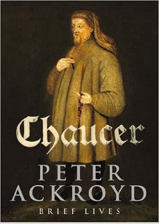

In [5]:
sample_url = df_img.iloc[0]["image_url"]
print(" URL m·∫´u:", sample_url)

img = fetch_image(sample_url)
if img:
    display(img)
else:
    print(" Kh√¥ng t·∫£i ƒë∆∞·ª£c ·∫£nh.")


In [6]:
from sentence_transformers import SentenceTransformer
import numpy as np

print("Model:", model)


Model: SentenceTransformer(
  (0): CLIPModel()
)


In [7]:
img = fetch_image(df_img.iloc[0]["image_url"])

if img:
    emb = model.encode(img, convert_to_numpy=True, normalize_embeddings=True)
    print(" Encode th√†nh c√¥ng!")
    print("Ki·ªÉu d·ªØ li·ªáu:", type(emb))
    print("K√≠ch th∆∞·ªõc vector:", emb.shape)
    print("Gi√° tr·ªã m·∫´u:", emb[:10])
else:
    print(" ·∫¢nh kh√¥ng t·∫£i ƒë∆∞·ª£c, th·ª≠ d√≤ng kh√°c.")


 Encode th√†nh c√¥ng!
Ki·ªÉu d·ªØ li·ªáu: <class 'numpy.ndarray'>
K√≠ch th∆∞·ªõc vector: (512,)
Gi√° tr·ªã m·∫´u: [ 0.00754738  0.00538931 -0.00163907  0.02669296 -0.00209506  0.01919868
 -0.00543011 -0.09512585 -0.00392603 -0.01375389]


In [8]:
for i in range(3):
    img = fetch_image(df_img.iloc[i]["image_url"])
    if img:
        emb = model.encode(img, convert_to_numpy=True, normalize_embeddings=True)
        print(f"·∫¢nh #{i} ‚Üí vector shape:", emb.shape)


·∫¢nh #0 ‚Üí vector shape: (512,)
·∫¢nh #1 ‚Üí vector shape: (512,)
·∫¢nh #2 ‚Üí vector shape: (512,)


In [9]:
import os, glob, numpy as np, pandas as pd
from tqdm import tqdm

BATCH_SIZE = 16
CHECKPOINT_EVERY = 200

IMG_COL = "main_images"
IMG_EMB_DIR = r"D:\BookInsight\data\embeddings\image"

CHECKPOINT_DIR = os.path.join(IMG_EMB_DIR, f"{IMG_COL}_checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

save_emb_path = os.path.join(IMG_EMB_DIR, f"image_embeddings_{IMG_COL}_shard0.npy")
save_meta_path = os.path.join(IMG_EMB_DIR, f"image_meta_{IMG_COL}_shard0.parquet")

print(" Embedding folder:", IMG_EMB_DIR)
print(" Checkpoint folder:", CHECKPOINT_DIR)


 Embedding folder: D:\BookInsight\data\embeddings\image
 Checkpoint folder: D:\BookInsight\data\embeddings\image\main_images_checkpoints


In [10]:
existing_ckpts = sorted(glob.glob(os.path.join(CHECKPOINT_DIR, "emb_*.npy")))

if existing_ckpts:
    last_ckpt = int(existing_ckpts[-1].split("_")[-1].split(".")[0])
    print(f" Resume from checkpoint #{last_ckpt}")
else:
    last_ckpt = 0
    print(" Starting from scratch")

df_img_resume = df_img.iloc[last_ckpt:].reset_index(drop=True)
print(" S·ªë ·∫£nh c·∫ßn x·ª≠ l√Ω:", len(df_img_resume))


 Starting from scratch
 S·ªë ·∫£nh c·∫ßn x·ª≠ l√Ω: 88964


In [11]:
import os
import time
import requests
from PIL import Image
from io import BytesIO

# üìÇ Th∆∞ m·ª•c cache ƒë·ªÉ l∆∞u ·∫£nh t·∫£i th√†nh c√¥ng (tr√°nh t·∫£i l·∫°i)
CACHE_DIR = r"D:\BookInsight\data\image_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

def fetch_image(url, max_size=(224, 224), retries=3, delay=1):
    """
    H√†m t·∫£i ·∫£nh c√≥ retry + cache + backoff ƒë·ªÉ tr√°nh timeout.
    - retries: s·ªë l·∫ßn th·ª≠ l·∫°i t·ªëi ƒëa
    - delay: th·ªùi gian ch·ªù gi·ªØa c√°c l·∫ßn retry
    - cache: l∆∞u ·∫£nh v√†o ·ªï ƒëƒ©a n·∫øu t·∫£i th√†nh c√¥ng
    """
    # B·ªè qua n·∫øu URL kh√¥ng h·ª£p l·ªá
    if not isinstance(url, str) or not url.startswith("http"):
        print(f"‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: {url}")
        return None

    # T√™n file cache (ch·ªâ l·∫•y ph·∫ßn cu·ªëi URL)
    fname = os.path.basename(url).split("?")[0]
    fpath = os.path.join(CACHE_DIR, fname)

    # N·∫øu ·∫£nh ƒë√£ cache r·ªìi -> load lu√¥n
    if os.path.exists(fpath):
        try:
            return Image.open(fpath).convert("RGB")
        except Exception:
            os.remove(fpath)  # xo√° file h·ªèng
            print(f"‚ö†Ô∏è File cache l·ªói, t·∫£i l·∫°i: {fname}")

    # D√πng session t√°i s·ª≠ d·ª•ng k·∫øt n·ªëi ƒë·ªÉ nhanh h∆°n
    session = requests.Session()

    for attempt in range(retries):
        try:
            r = session.get(url, timeout=8)
            r.raise_for_status()

            img = Image.open(BytesIO(r.content)).convert("RGB")
            img.thumbnail(max_size)
            img.save(fpath)  # l∆∞u cache
            return img

        except requests.exceptions.RequestException as e:
            # Retry v·ªõi exponential backoff
            if attempt < retries - 1:
                wait = delay * (2 ** attempt)
                print(f"‚ö†Ô∏è L·ªói t·∫£i ·∫£nh (th·ª≠ {attempt+1}/{retries}): {e} ‚Üí ƒë·ª£i {wait:.1f}s")
                time.sleep(wait)
            else:
                print(f"‚ùå B·ªè qua ·∫£nh sau {retries} l·∫ßn l·ªói: {url}")
                return None
        except Exception as e:
            print(f"‚ö†Ô∏è L·ªói x·ª≠ l√Ω ·∫£nh: {e}")
            return None


In [12]:
import os, glob, numpy as np, pandas as pd
from tqdm import tqdm

# =========================================================
# ‚öôÔ∏è C·∫•u h√¨nh
# =========================================================
BATCH_SIZE = 16
CHECKPOINT_EVERY = 200
IMG_COL = "main_images"

IMG_EMB_DIR = r"D:\BookInsight\data\embeddings\image"
CHECKPOINT_DIR = os.path.join(IMG_EMB_DIR, f"{IMG_COL}_checkpoints_test5000")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

save_emb_path = os.path.join(IMG_EMB_DIR, f"image_embeddings_{IMG_COL}_shard0_test5000.npy")
save_meta_path = os.path.join(IMG_EMB_DIR, f"image_meta_{IMG_COL}_shard0_test5000.parquet")

# =========================================================
# üì¶ L·∫•y 5 000 ·∫£nh ƒë·∫ßu ƒë·ªÉ test
# =========================================================
df_img_sample = df_img.head(5000).reset_index(drop=True)
print("üì∏ T·ªïng ·∫£nh test:", len(df_img_sample))

# =========================================================
# üîÅ Resume t·ª´ checkpoint n·∫øu c√≥
# =========================================================
existing_ckpts = sorted(glob.glob(os.path.join(CHECKPOINT_DIR, "emb_*.npy")))

if existing_ckpts:
    last_ckpt = int(existing_ckpts[-1].split("_")[-1].split(".")[0])
    print(f"üîÅ Resume t·ª´ checkpoint #{last_ckpt}")
else:
    last_ckpt = 0
    print("üöÄ B·∫Øt ƒë·∫ßu t·ª´ ƒë·∫ßu")

df_img_resume = df_img_sample.iloc[last_ckpt:].reset_index(drop=True)
print("üìä S·ªë ·∫£nh c·∫ßn x·ª≠ l√Ω:", len(df_img_resume))

# =========================================================
# üß† Encode loop
# =========================================================
embeddings, valid_meta = [], []

for i, row in tqdm(enumerate(df_img_resume.itertuples(), start=last_ckpt+1), total=len(df_img_sample)):
    img = fetch_image(row.image_url)
    if img is None:
        continue

    try:
        emb = model.encode(img, convert_to_numpy=True, normalize_embeddings=True)
        embeddings.append(emb)
        valid_meta.append({
            "unique_id": row.unique_id,
            "title": row.title,
            "image_url": row.image_url
        })
    except Exception as e:
        print(f"‚ö†Ô∏è L·ªói encode ·∫£nh {row.image_url}: {e}")
        continue

    if (i % CHECKPOINT_EVERY == 0) or (i == len(df_img_sample)):
        emb_array = np.vstack(embeddings)
        meta_df = pd.DataFrame(valid_meta)
        np.save(os.path.join(CHECKPOINT_DIR, f"emb_{i}.npy"), emb_array)
        meta_df.to_parquet(os.path.join(CHECKPOINT_DIR, f"meta_{i}.parquet"))
        print(f"üíæ Saved checkpoint t·∫°i ·∫£nh #{i}")
        embeddings, valid_meta = [], []


üì∏ T·ªïng ·∫£nh test: 5000
üîÅ Resume t·ª´ checkpoint #800
üìä S·ªë ·∫£nh c·∫ßn x·ª≠ l√Ω: 4200


  0%|          | 6/5000 [00:04<1:01:23,  1.36it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


  1%|          | 31/5000 [00:23<1:01:30,  1.35it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


  2%|‚ñè         | 98/5000 [01:16<1:04:05,  1.27it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


  2%|‚ñè         | 118/5000 [01:32<1:13:42,  1.10it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


  3%|‚ñé         | 136/5000 [01:44<56:39,  1.43it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


  3%|‚ñé         | 164/5000 [02:08<1:09:43,  1.16it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


  3%|‚ñé         | 167/5000 [02:09<55:17,  1.46it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


  4%|‚ñç         | 200/5000 [02:34<1:01:42,  1.30it/s]

üíæ Saved checkpoint t·∫°i ·∫£nh #1000


  5%|‚ñç         | 246/5000 [03:13<1:02:31,  1.27it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


  6%|‚ñå         | 276/5000 [03:36<1:11:53,  1.10it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


  6%|‚ñå         | 283/5000 [03:44<1:38:19,  1.25s/it]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


  7%|‚ñã         | 331/5000 [04:21<59:47,  1.30it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


  7%|‚ñã         | 363/5000 [04:44<57:03,  1.35it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


  8%|‚ñä         | 400/5000 [05:11<56:08,  1.37it/s]  

üíæ Saved checkpoint t·∫°i ·∫£nh #1200


  8%|‚ñä         | 414/5000 [05:23<1:12:25,  1.06it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


  8%|‚ñä         | 418/5000 [05:25<52:03,  1.47it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


  9%|‚ñâ         | 447/5000 [05:46<56:31,  1.34it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 10%|‚ñà         | 507/5000 [06:35<58:32,  1.28it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 11%|‚ñà         | 529/5000 [06:52<58:53,  1.27it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 12%|‚ñà‚ñè        | 600/5000 [07:50<56:29,  1.30it/s]  

üíæ Saved checkpoint t·∫°i ·∫£nh #1400


 12%|‚ñà‚ñè        | 617/5000 [08:03<54:41,  1.34it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 13%|‚ñà‚ñé        | 630/5000 [08:13<1:00:59,  1.19it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 13%|‚ñà‚ñé        | 663/5000 [08:42<50:48,  1.42it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 14%|‚ñà‚ñç        | 696/5000 [09:04<50:00,  1.43it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 14%|‚ñà‚ñç        | 707/5000 [09:12<54:07,  1.32it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 15%|‚ñà‚ñç        | 746/5000 [09:41<1:02:33,  1.13it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 15%|‚ñà‚ñå        | 758/5000 [09:50<58:10,  1.22it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 16%|‚ñà‚ñå        | 800/5000 [10:27<1:23:31,  1.19s/it]

üíæ Saved checkpoint t·∫°i ·∫£nh #1600


 16%|‚ñà‚ñã        | 814/5000 [10:39<1:01:09,  1.14it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 18%|‚ñà‚ñä        | 882/5000 [11:33<45:06,  1.52it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 19%|‚ñà‚ñä        | 932/5000 [12:09<53:57,  1.26it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 20%|‚ñà‚ñâ        | 994/5000 [12:59<58:04,  1.15it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 20%|‚ñà‚ñà        | 1000/5000 [13:03<50:28,  1.32it/s]

üíæ Saved checkpoint t·∫°i ·∫£nh #1800


 21%|‚ñà‚ñà        | 1038/5000 [13:36<53:38,  1.23it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 23%|‚ñà‚ñà‚ñé       | 1141/5000 [15:01<52:42,  1.22it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 24%|‚ñà‚ñà‚ñé       | 1182/5000 [15:37<54:21,  1.17it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 24%|‚ñà‚ñà‚ñç       | 1196/5000 [15:48<53:21,  1.19it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 24%|‚ñà‚ñà‚ñç       | 1200/5000 [15:50<47:21,  1.34it/s]

üíæ Saved checkpoint t·∫°i ·∫£nh #2000


 24%|‚ñà‚ñà‚ñç       | 1223/5000 [16:08<49:31,  1.27it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 25%|‚ñà‚ñà‚ñå       | 1265/5000 [16:43<51:54,  1.20it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 27%|‚ñà‚ñà‚ñã       | 1326/5000 [17:33<49:12,  1.24it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 27%|‚ñà‚ñà‚ñã       | 1328/5000 [17:33<37:17,  1.64it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 28%|‚ñà‚ñà‚ñä       | 1400/5000 [18:28<46:24,  1.29it/s]

üíæ Saved checkpoint t·∫°i ·∫£nh #2200


 29%|‚ñà‚ñà‚ñâ       | 1447/5000 [19:03<44:07,  1.34it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 30%|‚ñà‚ñà‚ñà       | 1514/5000 [19:53<40:50,  1.42it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 31%|‚ñà‚ñà‚ñà       | 1527/5000 [20:03<45:38,  1.27it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 32%|‚ñà‚ñà‚ñà‚ñè      | 1600/5000 [20:53<37:18,  1.52it/s]

üíæ Saved checkpoint t·∫°i ·∫£nh #2400


 35%|‚ñà‚ñà‚ñà‚ñç      | 1726/5000 [22:37<46:41,  1.17it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 35%|‚ñà‚ñà‚ñà‚ñå      | 1769/5000 [23:17<49:55,  1.08it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 36%|‚ñà‚ñà‚ñà‚ñå      | 1800/5000 [23:45<47:03,  1.13it/s]

üíæ Saved checkpoint t·∫°i ·∫£nh #2600


 36%|‚ñà‚ñà‚ñà‚ñã      | 1817/5000 [24:00<51:55,  1.02it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 37%|‚ñà‚ñà‚ñà‚ñã      | 1852/5000 [24:29<39:50,  1.32it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 37%|‚ñà‚ñà‚ñà‚ñã      | 1869/5000 [24:42<40:31,  1.29it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 38%|‚ñà‚ñà‚ñà‚ñä      | 1883/5000 [24:52<38:07,  1.36it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1976/5000 [26:23<42:31,  1.18it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1987/5000 [26:30<34:39,  1.45it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 40%|‚ñà‚ñà‚ñà‚ñà      | 2000/5000 [26:41<40:51,  1.22it/s]

üíæ Saved checkpoint t·∫°i ·∫£nh #2800


 40%|‚ñà‚ñà‚ñà‚ñà      | 2001/5000 [26:41<38:38,  1.29it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2135/5000 [28:40<38:34,  1.24it/s]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2153/5000 [28:53<33:40,  1.41it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2170/5000 [29:06<35:40,  1.32it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 2176/5000 [29:11<39:45,  1.18it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2198/5000 [29:26<31:33,  1.48it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2200/5000 [29:26<24:13,  1.93it/s]

üíæ Saved checkpoint t·∫°i ·∫£nh #3000


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2219/5000 [29:40<31:57,  1.45it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2255/5000 [30:11<46:08,  1.01s/it]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2293/5000 [30:44<34:13,  1.32it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 2351/5000 [31:28<31:06,  1.42it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2392/5000 [32:01<36:31,  1.19it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2394/5000 [32:01<27:50,  1.56it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2400/5000 [32:06<34:04,  1.27it/s]

üíæ Saved checkpoint t·∫°i ·∫£nh #3200


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2404/5000 [32:10<37:04,  1.17it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2409/5000 [32:13<32:26,  1.33it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2420/5000 [32:21<39:22,  1.09it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2425/5000 [32:24<31:42,  1.35it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2441/5000 [32:38<36:16,  1.18it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2484/5000 [33:13<32:06,  1.31it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2597/5000 [34:43<33:15,  1.20it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2600/5000 [34:44<25:31,  1.57it/s]

üíæ Saved checkpoint t·∫°i ·∫£nh #3400


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2602/5000 [34:46<29:51,  1.34it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2629/5000 [35:08<35:22,  1.12it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2669/5000 [35:40<33:13,  1.17it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2693/5000 [36:00<32:22,  1.19it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2700/5000 [36:08<59:29,  1.55s/it]  

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2750/5000 [36:50<35:52,  1.05it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2780/5000 [37:12<26:35,  1.39it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2800/5000 [37:28<27:02,  1.36it/s]

üíæ Saved checkpoint t·∫°i ·∫£nh #3600


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2815/5000 [37:40<30:52,  1.18it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2839/5000 [38:01<30:23,  1.19it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2895/5000 [38:48<26:52,  1.31it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2943/5000 [39:24<25:24,  1.35it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 3000/5000 [40:08<28:39,  1.16it/s]

üíæ Saved checkpoint t·∫°i ·∫£nh #3800


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 3018/5000 [40:21<27:01,  1.22it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 3056/5000 [40:49<29:41,  1.09it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 3059/5000 [40:52<26:24,  1.22it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 3064/5000 [40:56<28:54,  1.12it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 3105/5000 [41:30<22:52,  1.38it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown
‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 3113/5000 [41:35<26:48,  1.17it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 3163/5000 [42:16<23:33,  1.30it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3200/5000 [42:47<25:32,  1.17it/s]

üíæ Saved checkpoint t·∫°i ·∫£nh #4000


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3221/5000 [43:08<31:40,  1.07s/it]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 3354/5000 [45:02<21:12,  1.29it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3387/5000 [45:29<20:02,  1.34it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3394/5000 [45:34<20:49,  1.29it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3400/5000 [45:40<25:46,  1.03it/s]

üíæ Saved checkpoint t·∫°i ·∫£nh #4200


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3600/5000 [48:46<20:52,  1.12it/s]

üíæ Saved checkpoint t·∫°i ·∫£nh #4400


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3610/5000 [48:54<20:15,  1.14it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3634/5000 [49:14<18:12,  1.25it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3649/5000 [49:25<18:43,  1.20it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3661/5000 [49:35<20:05,  1.11it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 3668/5000 [49:42<21:07,  1.05it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3695/5000 [50:03<18:01,  1.21it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3738/5000 [50:38<20:26,  1.03it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3743/5000 [50:41<15:17,  1.37it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3800/5000 [51:27<15:04,  1.33it/s]

üíæ Saved checkpoint t·∫°i ·∫£nh #4600


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3815/5000 [51:40<18:28,  1.07it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3821/5000 [51:44<14:44,  1.33it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3913/5000 [53:08<18:26,  1.02s/it]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3941/5000 [53:33<14:16,  1.24it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3991/5000 [54:13<12:28,  1.35it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 4000/5000 [54:19<12:01,  1.39it/s]

üíæ Saved checkpoint t·∫°i ·∫£nh #4800


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 4027/5000 [54:41<13:51,  1.17it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 4111/5000 [56:00<13:59,  1.06it/s]

‚ö†Ô∏è URL kh√¥ng h·ª£p l·ªá: Unknown


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4200/5000 [57:17<10:54,  1.22it/s]

üíæ Saved checkpoint t·∫°i ·∫£nh #5000


In [1]:
import glob
import numpy as np
import pandas as pd
import os

IMG_COL = "main_images"
IMG_EMB_DIR = r"D:\BookInsight\data\embeddings\image"
CHECKPOINT_DIR = os.path.join(IMG_EMB_DIR, f"{IMG_COL}_checkpoints_test5000")

save_emb_path = os.path.join(IMG_EMB_DIR, f"image_embeddings_{IMG_COL}_shard0_test5000.npy")
save_meta_path = os.path.join(IMG_EMB_DIR, f"image_meta_{IMG_COL}_shard0_test5000.parquet")

all_ckpts = sorted(glob.glob(os.path.join(CHECKPOINT_DIR, "emb_*.npy")))
meta_ckpts = sorted(glob.glob(os.path.join(CHECKPOINT_DIR, "meta_*.parquet")))

print(f"T√¨m th·∫•y {len(all_ckpts)} file embedding v√† {len(meta_ckpts)} file metadata")

emb_arrays = [np.load(f) for f in all_ckpts]
final_emb = np.vstack(emb_arrays)
np.save(save_emb_path, final_emb)
print("ƒê√£ l∆∞u embedding h·ª£p nh·∫•t ", save_emb_path)

meta_dfs = [pd.read_parquet(f) for f in meta_ckpts]
final_meta = pd.concat(meta_dfs, ignore_index=True)
final_meta.to_parquet(save_meta_path)
print(" ƒê√£ l∆∞u metadata h·ª£p nh·∫•t ", save_meta_path)

print(" K√≠ch th∆∞·ªõc embedding cu·ªëi c√πng:", final_emb.shape)
print(" S·ªë d√≤ng metadata:", len(final_meta))


T√¨m th·∫•y 25 file embedding v√† 25 file metadata
ƒê√£ l∆∞u embedding h·ª£p nh·∫•t  D:\BookInsight\data\embeddings\image\image_embeddings_main_images_shard0_test5000.npy
 ƒê√£ l∆∞u metadata h·ª£p nh·∫•t  D:\BookInsight\data\embeddings\image\image_meta_main_images_shard0_test5000.parquet
 K√≠ch th∆∞·ªõc embedding cu·ªëi c√πng: (4882, 512)
 S·ªë d√≤ng metadata: 4882


In [2]:
import faiss
import numpy as np
import pandas as pd
import os

IMG_EMB_DIR = r"D:\BookInsight\data\embeddings\image"
VECTORSTORE_DIR = r"D:\BookInsight\data\vectorstores\image_faiss\shard_0"
os.makedirs(VECTORSTORE_DIR, exist_ok=True)

emb_path = os.path.join(IMG_EMB_DIR, "image_embeddings_main_images_shard0_test5000.npy")
meta_path = os.path.join(IMG_EMB_DIR, "image_meta_main_images_shard0_test5000.parquet")

embeddings = np.load(emb_path)
metadata = pd.read_parquet(meta_path)
print(" Loaded embeddings:", embeddings.shape)
print(" Loaded metadata:", metadata.shape)


 Loaded embeddings: (4882, 512)
 Loaded metadata: (4882, 3)


In [3]:
dim = embeddings.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings.astype("float32"))

print(" FAISS index created & populated with:", index.ntotal, "vectors")

faiss.write_index(index, os.path.join(VECTORSTORE_DIR, "index.faiss"))
metadata.to_pickle(os.path.join(VECTORSTORE_DIR, "index.pkl"))

print(" Saved FAISS index and metadata to:")
print(VECTORSTORE_DIR)


 FAISS index created & populated with: 4882 vectors
 Saved FAISS index and metadata to:
D:\BookInsight\data\vectorstores\image_faiss\shard_0


 ·∫¢nh g·ªëc (id=78):


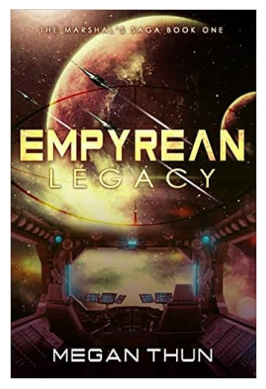

 10 ·∫£nh t∆∞∆°ng t·ª±:


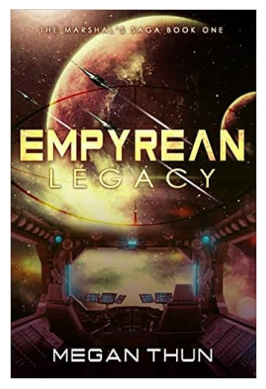

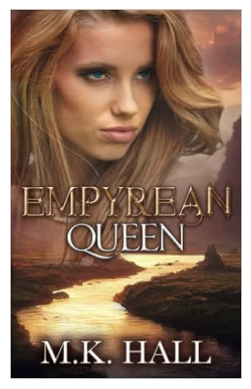

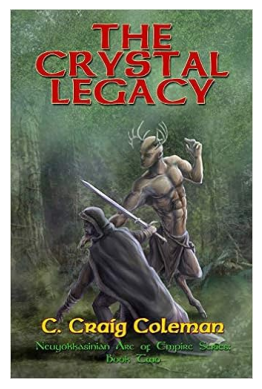

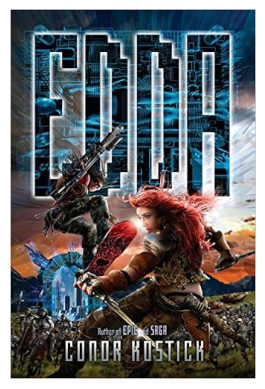

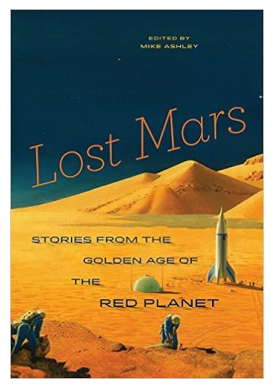

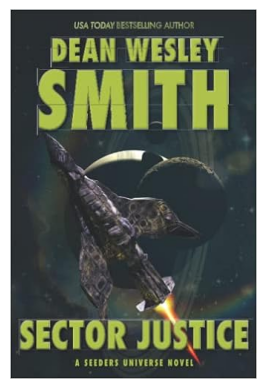

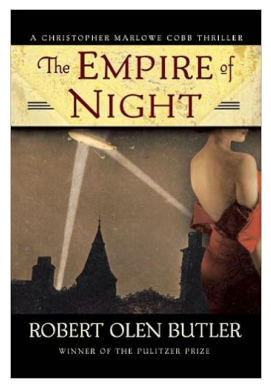

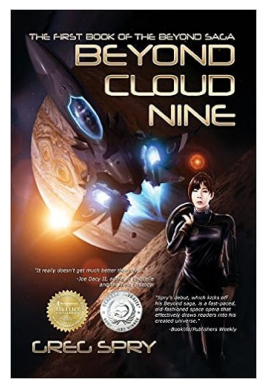

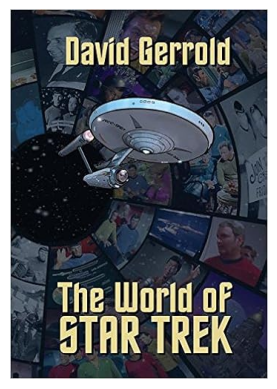

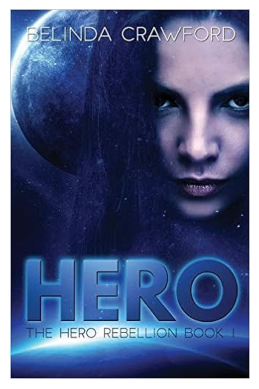

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

def show_image_from_url(url):
    try:
        r = requests.get(url, timeout=5)
        r.raise_for_status()
        img = Image.open(BytesIO(r.content)).convert("RGB")
        plt.imshow(img)
        plt.axis("off")
        plt.show()
    except:
        print(" Kh√¥ng hi·ªÉn th·ªã ƒë∆∞·ª£c ·∫£nh:", url)

# test query
query_id = 78
query_vec = embeddings[query_id].reshape(1, -1)
D, I = index.search(query_vec.astype("float32"), k=10)

print(f" ·∫¢nh g·ªëc (id={query_id}):")
show_image_from_url(metadata.iloc[query_id].image_url)

print(" 10 ·∫£nh t∆∞∆°ng t·ª±:")
for idx in I[0]:
    show_image_from_url(metadata.iloc[idx].image_url)
